# Multi-fidelity deep GP
## Application to random functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model
from MFRBF import MFRBF

In [237]:
def f_low(x,w):
    tmp = 0.
    for i in range(len(w)):
        tmp = tmp+np.cos(w[i]*x)/len(w)
    return tmp
    
def f_high(x,w):
    tmp = 0.
    for i in range(len(w)-1):
        tmp = tmp + np.cos(w[i]*x)/(len(w)-1)
    tmp = tmp * np.cos(w[-1]*x+np.pi/6)
    return tmp

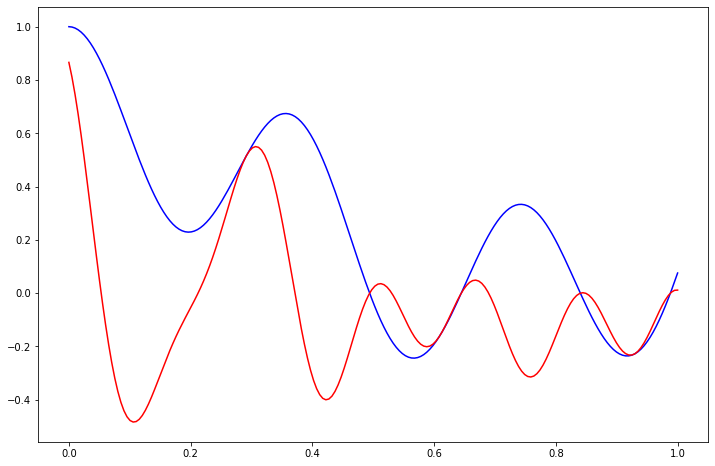

In [540]:
#np.random.seed(59)
#np.random.seed(129)
np.random.seed(89)
#np.random.seed(19)

w1 = np.random.normal(0,10,3).reshape(-1,1)
w2 = np.random.normal(20,1,1).reshape(-1,1)
w3 = np.vstack((w1,w2))

X_plot = np.linspace(0,1,200)[:,None]
f_c=f_low(X_plot,w1)
f_e=f_high(X_plot,w3)

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(X_plot,f_c,'b-')
plt.plot(X_plot,f_e,'r-')
plt.show()

In [541]:
print(w3)

[[-16.93730027]
 [ -0.02121333]
 [ -4.2589184 ]
 [ 19.74440954]]


In [542]:
num_cheap = 50
num_expensive = 10

#num_cheap = 24
#num_expensive = 5

#num_cheap = 12
#num_expensive = 5

X1 = np.linspace(0,1,num_cheap)[:,None]
#X2 = np.linspace(0,1,num_expensive)[:,None]
X2 = np.random.rand(num_expensive)[:,None]

In [543]:
noise_level = 0.1

#Yc = f_high(X1,w1)+ noise_level * np.random.normal(0,1,num_cheap)[:,None]
Yc = f_low(X1,w1)+ noise_level * np.random.normal(0,1,num_cheap)[:,None]

Ye = f_high(X2,w3) + 0.001 * np.random.normal(0,1,num_expensive)[:,None]

Optimization restart 1/10, f = -22.69703044758285
Optimization restart 2/10, f = 4.458511409298975
Optimization restart 3/10, f = -22.697030448579245
Optimization restart 4/10, f = 4.458511409287109
Optimization restart 5/10, f = 4.458511409292672
Optimization restart 6/10, f = 4.458511409286945
Optimization restart 7/10, f = 4.45851140928961
Optimization restart 8/10, f = 4.458511409286995
Optimization restart 9/10, f = -22.697030446871388
Optimization restart 10/10, f = 4.4585114094269755


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fa753f30b10>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fa753f5ab10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fa753f5a9d0>]}

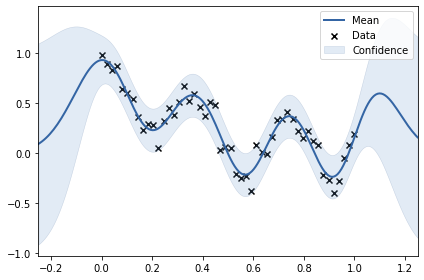

In [544]:
m1 = GPy.models.GPRegression(X1, Yc)
m1.kern.lengthscale=0.1
m1.optimize_restarts(num_restarts = 10)
m1.plot()

In [545]:
mu, v = m1.predict(X2, full_cov = True)

In [546]:
deepKern = MFRBF(input_dim=1, variance = 1, lengthscale = 1, mu = mu, v=v)
K1 = deepKern.K(X2)

In [547]:
kRBF = GPy.kern.RBF(input_dim = 1)

In [548]:
effKern = kRBF * deepKern


In [549]:
m2 = GPy.models.GPRegression(X2, Ye, effKern)

In [550]:
m2.optimize()
m2.optimize(messages=True)
m2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 3.440518132311685
Optimization restart 2/10, f = 3.4405185764652995
Optimization restart 3/10, f = 3.4405211600644128
Optimization restart 4/10, f = 3.440518289741158
Optimization restart 5/10, f = 3.4405239571260635
Optimization restart 6/10, f = 3.440518084634843
Optimization restart 7/10, f = 1.7222625213946428
Optimization restart 8/10, f = 3.440517223068417
Optimization restart 9/10, f = 3.9646172146654024
Optimization restart 10/10, f = 3.440516322529086


In [551]:
print(m2)


Name : GP regression
Objective : 1.7222625213946428
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  mul.rbf.variance         |  0.00016558867634522984  |      +ve      |        
  mul.rbf.lengthscale      |      0.0379210461040834  |      +ve      |        
  mul.MFRBF.variance       |       -25.9990735495808  |               |        
  mul.MFRBF.lengtscale     |      -299.2032275872625  |               |        
  Gaussian_noise.variance  |  2.641594061941077e-283  |      +ve      |        


In [552]:
print(m2.kern.rbf.variance[0])

0.00016558867634522984


In [553]:
s1=m2.kern.rbf.variance[0]
l1=m2.kern.rbf.lengthscale[0]
s2=m2.kern.MFRBF.variance[0]
l2=m2.kern.MFRBF.lengthscale[0]

X_test = np.linspace(0,1,99)[:,None]
Y_test=[]
Y_test_up=[]
Y_test_down=[]

def predict_eff(CovMtx, Y):
    K_ee = CovMtx[1:,1:]
    K_e = CovMtx[0,1:]
    K_inv = np.linalg.inv(K_ee+0.0001*np.eye(K_ee.shape[0]))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0,0] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, np.sqrt(pred_v)



for xx in X_test:
    Xnew = np.vstack((xx,X2))
    mu1, v1 = m1.predict(Xnew, full_cov = True)
    kernMF = MFRBF(input_dim=1,variance = s2, lengthscale = l2, mu = mu1, v=v1)
    kernRBF = GPy.kern.RBF(input_dim = 1, variance = s1, lengthscale = l1)
    M1 = kernMF.K(Xnew)
    M2 = kernRBF.K(Xnew)
    GG = np.multiply(M1, M2)
    
    pred_mu, pred_v = predict_eff(GG, Ye)
    
    Y_test.append(pred_mu)
    Y_test_up.append(pred_mu+1.96*pred_v)
    Y_test_down.append(pred_mu-1.96*pred_v)
    
    

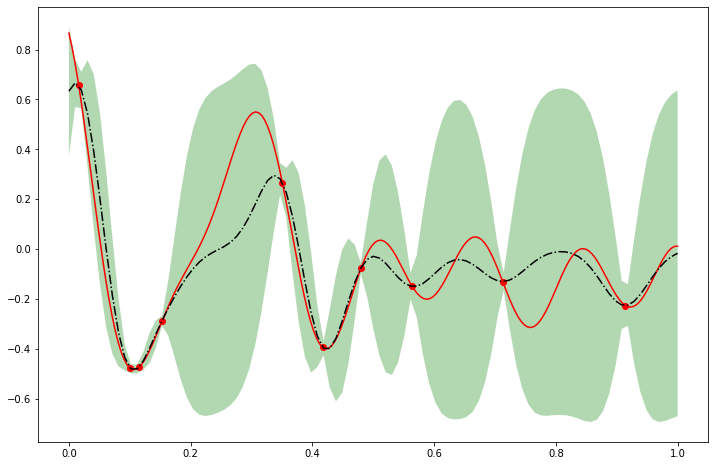

In [554]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(X2,Ye,'ro')
plt.plot(X_plot,f_e,'r-')
#plt.plot(X_plot,f_c,'b.')
plt.plot(X_test,Y_test,'k-.')
plt.fill_between(np.array(X_test).flatten(),np.array(Y_test_up).flatten(),np.array(Y_test_down).flatten(),facecolor='g',alpha=0.3)
plt.show()

## Applying single GP to expensive data only

Optimization restart 1/10, f = 3.9447851057185046
Optimization restart 2/10, f = 3.9447747648595435
Optimization restart 3/10, f = 3.944773909240954
Optimization restart 4/10, f = 3.9447736923762724
Optimization restart 5/10, f = 3.9447738551487923
Optimization restart 6/10, f = 3.9447845383870606
Optimization restart 7/10, f = 3.9447737315784064
Optimization restart 8/10, f = 3.9448023520343245
Optimization restart 9/10, f = 3.944773710676193
Optimization restart 10/10, f = 3.944773872598639


(0.0, 1.0)

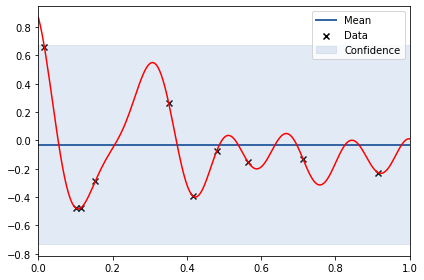

In [555]:
m3 = GPy.models.GPRegression(X2, Ye)
m3.optimize_restarts(num_restarts = 10)
m3.plot()
plt.plot(X_plot,f_e,'r-')
plt.xlim([0,1])

## Multi-output GP

In [556]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Yc,Ye],kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()

In [557]:
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,16))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,num_cheap),ax=ax1)
    #m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],ax=ax1)
    ax1.plot(Xt1[:,:1],Yt1,'r.',mew=1.5)
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(num_cheap,num_cheap+num_expensive),ax=ax2)
    #m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],ax=ax2)
    ax2.plot(Xt2[:,:1],Yt2,'r.',mew=1.5)



In [558]:
Xt1 = np.random.rand(100)[:,None]*1.2
Xt2 = np.random.rand(100)[:,None]*1.2

Yt1 = f_low(Xt1,w1)
Yt2 = f_high(Xt2,w3)

Populating the interactive namespace from numpy and matplotlib


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:pylab import has clobbered these variables: ['lcm']
`%matplotlib` prevents importing * from pylab and numpy


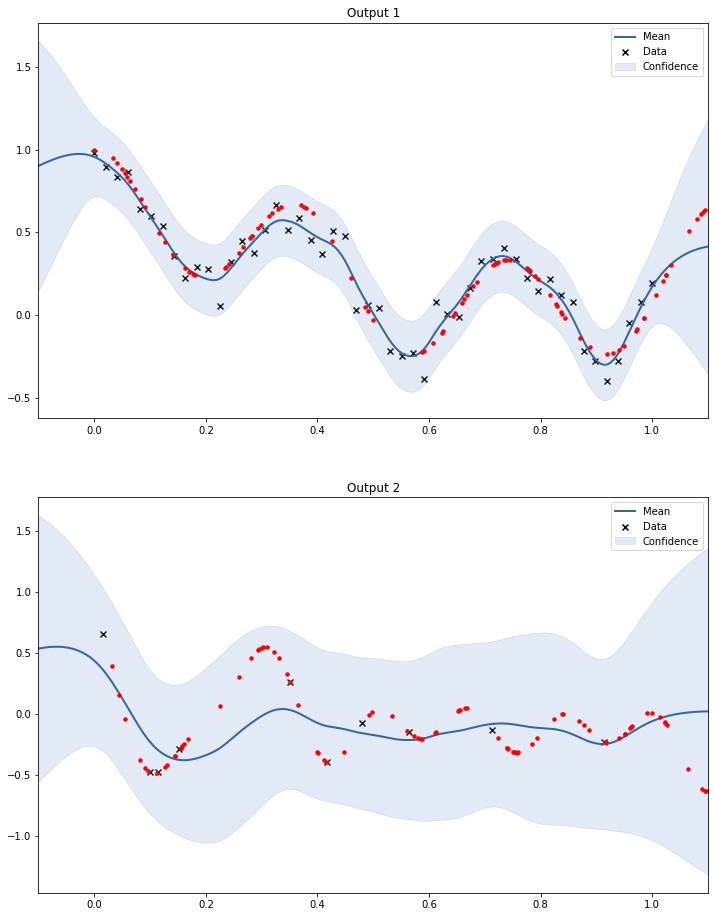

In [559]:
%pylab inline
import pylab as pb
pylab.ion()

plot_2outputs(m,xlim=(-0.1,1.1),ylim=(-2,2))